In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import missingno as msn
import dexplot as dxp
import time
import gc
import numpy as np
from scipy.stats import spearmanr
from datetime import timedelta

In [2]:

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import lightgbm as lgb

In [3]:
###reading in training set

train=pd.read_csv("training_set_VU_DM.csv")
#test=pd.read_csv("test_set_VU_DM.csv")


In [4]:
## dropping columns with high nulls

to_drop= ['comp1_rate',
'comp1_inv',
'comp1_rate_percent_diff',
'comp2_rate',
'comp2_inv',
'comp2_rate_percent_diff',
'comp3_rate',
'comp3_inv',
'comp3_rate_percent_diff',
'comp4_rate',
'comp4_inv',
'comp4_rate_percent_diff',
'comp5_rate',
'comp5_inv',
'comp5_rate_percent_diff',
'comp6_rate',
'comp6_inv',
'comp6_rate_percent_diff',
'comp7_rate',
'comp7_inv',
'comp7_rate_percent_diff',
'comp8_rate',
'comp8_inv',
'comp8_rate_percent_diff'

]



#creating dependant variabe 
conditions = [
    (train['booking_bool']> 0),
    (train['click_bool']> 0)
]

choices = [5 ,1]
train['outcome'] = np.select(conditions, choices, default=0)

train = train.drop(to_drop,  axis=1)#.sample(frac=0.2, replace=True, random_state=1)

#filtering out price outliers 
train = train[train.price_usd < 3001]

In [67]:
    ## creating time related features
    
    train['date_time'] = pd.to_datetime(train['date_time'], errors='coerce')
    train["weekday"] = train["date_time"].dt.weekday
    train["week_of_year"] = train["date_time"].dt.week
    train["month"] = train["date_time"].dt.month
    train["hour"] = train["date_time"].dt.hour
    ## total time elapsed - allows model to learn continous trend over time to a degree
    train["time_epoch"] = train["date_time"].astype('int64')//1e9
    train.loc[ train['hour'] < 6, 'day_time'] = 1
    train.loc[(train['hour'] >=6) & (train['hour'] <= 11), 'day_time'] = 2
    train.loc[(train['hour'] >= 12) & (train['hour'] <= 17), 'day_time'] = 3
    train.loc[(train['hour'] > 18) , 'day_time'] = 4

NameError: name 'train' is not defined

In [68]:
#more time related features

train['srch_for_date'] = train['date_time']  + pd.to_timedelta(train['srch_booking_window'], unit='D')
train["srch_for_month"] = train["srch_for_date"].dt.month
train.loc[ train['srch_for_month'] <= 3, 'seasonality'] = 1
train.loc[(train['srch_for_month'] > 3) & (train['srch_for_month'] <= 6), 'seasonality'] = 2
train.loc[(train['srch_for_month'] > 6) & (train['srch_for_month'] <= 9), 'seasonality'] = 3
train.loc[(train['srch_for_month'] > 9) , 'seasonality'] = 4

train.loc[ train['month'] <= 3, 'qrtr'] = 1
train.loc[(train['month'] > 3) & (train['month'] <= 6), 'qrtr'] = 2
train.loc[(train['month'] > 6) & (train['month'] <= 9), 'qrtr'] = 3
train.loc[(train['month'] > 9) , 'qrtr'] = 4

NameError: name 'train' is not defined

In [69]:
#filling in missing values for prop_review_score and prop_starrating using average rating 
#based off similar priced hotels 
train['price_bin'] = pd.qcut(train['price_usd'], q=80, precision=0)
train['mean_price_bin_star'] = train.groupby('price_bin')['prop_starrating'].transform('mean')
train['mean_price_bin_review'] = train.groupby('price_bin')['prop_review_score'].transform('mean')
train['prop_review_score'] = train['prop_review_score'].fillna(0)
train.loc[train.prop_review_score == 0, "prop_review_score"] = train.mean_price_bin_review
train.loc[train.prop_starrating == 0, "prop_starrating"] = train.mean_price_bin_star



NameError: name 'train' is not defined

In [70]:
#comparing price for hotels with other hotels in the same search

train['max_price'] = train.groupby('srch_id')['price_usd'].transform('max') 
train['min_price'] = train.groupby('srch_id')['price_usd'].transform('min') 
train['mean_price'] = train.groupby('srch_id')['price_usd'].transform('mean') 
train['diff_max_price'] =(train['max_price'] -train['price_usd']) / train['price_usd']
train['diff_min_price'] = (train['min_price'] - train['price_usd'])/ train['price_usd']
train['diff_min_price'] = train['diff_min_price'].replace(np.nan, 0)
train['diff_mean_price'] = (train['mean_price'] - train['price_usd']) / train['price_usd']
train['price_review_value'] =  train['prop_review_score'] /train['mean_price_bin_review'] 


NameError: name 'train' is not defined

In [9]:
# getting actual click and booking statistics for each hotel & if there was a booking - how many adults,children,rooms

train['hotel_show_prob'] =  train.groupby('prop_id')['prop_id'].transform('count') / (train.srch_id.unique()).size
train_calcs = train[train.booking_bool == 1]
train_calcs['hotel_avg_children'] = train_calcs.groupby('prop_id')['srch_children_count'].transform('mean') 
train_calcs['hotel_avg_adult'] = train_calcs.groupby('prop_id')['srch_adults_count'].transform('mean') 
train_calcs['hotel_avg_stay'] = train_calcs.groupby('prop_id')['srch_length_of_stay'].transform('mean') 
train_calcs['hotel_avg_room_count'] = train_calcs.groupby('prop_id')['srch_room_count'].transform('mean') 
train_calcs['bought'] = train_calcs.groupby('prop_id')['booking_bool'].transform('sum') 
train_calcs = train_calcs[['prop_id','hotel_avg_children', 'hotel_avg_adult', 'hotel_avg_stay','hotel_avg_room_count','bought']]

#pd.crosstab(train.hotel_click_prob, train.prop_id, dropna=False)
train_calcs = train_calcs.drop_duplicates(subset=['prop_id'])

train['hotel_buy_prob'] = train.groupby('prop_id')['booking_bool'].transform('sum') / train.groupby('prop_id')['booking_bool'].transform('count')
train['hotel_click_prob'] = train.groupby('prop_id')['click_bool'].transform('sum') / train.groupby('prop_id')['click_bool'].transform('count')
train['hotel_qrtr_buy_prob'] = train.groupby(['qrtr','prop_id'])['booking_bool'].transform('sum') / train.groupby(['qrtr','prop_id'])['booking_bool'].transform('count')
train['hotel_qrtr_click_prob'] = train.groupby(['qrtr','prop_id'])['click_bool'].transform('sum') / train.groupby(['qrtr','prop_id'])['click_bool'].transform('count')
train['hotel_srch_sesn_buy_prob'] = train.groupby(['seasonality','prop_id'])['booking_bool'].transform('sum') / train.groupby(['seasonality','prop_id'])['booking_bool'].transform('count')
train['hotel_srch_sesn_click_prob'] = train.groupby(['seasonality','prop_id'])['click_bool'].transform('sum') / train.groupby(['seasonality','prop_id'])['click_bool'].transform('count')


hotel_click_stats = train[['prop_id', 'hotel_buy_prob','hotel_click_prob', 'hotel_qrtr_click_prob', 'hotel_qrtr_buy_prob', 'hotel_srch_sesn_buy_prob','hotel_srch_sesn_click_prob']]

C:\Users\Admin\AppData\Local\Temp\ipykernel_12332\56183062.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_calcs['hotel_avg_children'] = train_calcs.groupby('prop_id')['srch_children_count'].transform('mean')
C:\Users\Admin\AppData\Local\Temp\ipykernel_12332\56183062.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_calcs['hotel_avg_adult'] = train_calcs.groupby('prop_id')['srch_adults_count'].transform('mean')
C:\Users\Admin\AppData\Local\Temp\ipykernel_12332\56183062.py:7: SettingWithCop

In [10]:
## balancing the dataset - at first balanced it 50:50 but now balancing it 33:66

#train_reduced = train.groupby('outcome')
#print(train_reduced.size().min()*2)
#train_reduced = pd.DataFrame(train_reduced.apply(lambda x: x.sample((train_reduced.size().min()*2),  replace=True).reset_index(drop=True)))
#train_reduced = pd.DataFrame(train_reduced.apply(lambda x: x.sample((train_reduced.size().min()),  replace=True).reset_index(drop=True)))

# df = train[train.outcome == 1]
# df1 = train[train.outcome == 0]
# df1 = df1.sample(n=len(df)*2)

# frames = [df, df1]

# train_reduced = pd.concat(frames)

In [11]:
train_reduced = train
### merging hotel specific cals to main dataset 
train_reduced = train_reduced.merge(train_calcs, left_on=['prop_id'], right_on=['prop_id'], how='left')
train_reduced['hotel_avg_children'] = train_reduced['hotel_avg_children'].replace(np.nan, .367)
train_reduced['hotel_avg_adult'] = train_reduced['hotel_avg_adult'].replace(np.nan, 1.95)
train_reduced['hotel_avg_stay'] = train_reduced['hotel_avg_stay'].replace(np.nan, 2.09)
train_reduced['hotel_avg_room_count'] = train_reduced['hotel_avg_room_count'].replace(np.nan, 1.13)


In [12]:
train_reduced.head(10)

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,hotel_click_prob,hotel_qrtr_buy_prob,hotel_qrtr_click_prob,hotel_srch_sesn_buy_prob,hotel_srch_sesn_click_prob,hotel_avg_children,hotel_avg_adult,hotel_avg_stay,hotel_avg_room_count,bought
0,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,893,3.0,3.500000,...,0.026144,0.018727,0.041199,0.026201,0.052402,0.100000,1.600000,1.800000,1.100000,10.0
1,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,10404,4.0,4.000000,...,0.025773,0.027027,0.040541,0.009569,0.019139,0.333333,2.000000,1.666667,1.333333,9.0
2,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,21315,3.0,4.500000,...,0.009091,0.004444,0.008889,0.004808,0.014423,0.000000,3.500000,1.000000,1.500000,2.0
3,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,27348,2.0,4.000000,...,0.023965,0.027027,0.047297,0.014184,0.028369,0.000000,1.833333,1.000000,1.000000,6.0
4,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,29604,4.0,3.500000,...,0.051205,0.043307,0.055118,0.044177,0.056225,0.416667,1.666667,1.541667,1.208333,24.0
5,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,30184,4.0,4.500000,...,0.045171,0.037037,0.065844,0.022222,0.057778,0.857143,2.000000,2.142857,1.071429,14.0
6,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,44147,3.0,3.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.367000,1.950000,2.090000,1.130000,NaN
7,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,50984,2.0,3.585042,...,0.019231,0.019608,0.019608,0.025641,0.025641,0.500000,2.000000,1.500000,1.000000,2.0
8,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,53341,4.0,4.000000,...,0.117424,0.075145,0.098266,0.083851,0.118012,0.271429,1.642857,1.228571,1.114286,70.0
9,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,56880,4.0,4.000000,...,0.056380,0.051095,0.069343,0.051181,0.062992,0.461538,1.769231,1.538462,1.269231,26.0


In [13]:
#dropped price bin
train_reduced = train_reduced.drop(['price_bin'], axis = 1)
#train_reduced.to_csv('hotel_calcs2.csv')

In [14]:
#checking %% of nulls in the dataset 
train_reduced.isnull().mean() * 100

srch_id                         0.000000
date_time                       0.000000
site_id                         0.000000
visitor_location_country_id     0.000000
visitor_hist_starrating        94.917018
                                 ...    
hotel_avg_children              0.000000
hotel_avg_adult                 0.000000
hotel_avg_stay                  0.000000
hotel_avg_room_count            0.000000
bought                         25.545258
Length: 62, dtype: float64

In [15]:
# plt.figure(figsize=(15, 6))
# sns.heatmap(train_reduced.corr().abs(),  annot=True)

In [16]:
# ###### next few sections are some general charts exploring the data

# ax = sns.histplot(x = train_reduced['random_bool'], hue=train_reduced['random_bool'] ,
#                   stat = 'percent', shrink =10, common_norm=True)

In [17]:
# #ax = sns.histplot(x = train_reduced['random_bool'], hue=train_reduced['random_bool'], multiple="dodge", 
# #train_reduced = train_reduced.reset_index()
# ax = sns.histplot(x = train_reduced['click_bool'], hue=train_reduced['click_bool'] ,
#                   stat = 'percent', shrink =4,common_norm=True)

In [18]:
# #ax = sns.histplot(x = train_reduced['random_bool'], hue=train_reduced['random_bool'], multiple="dodge", 
# #train_reduced = train_reduced.reset_index()
# ax = sns.histplot(x = train_reduced['promotion_flag'], hue=train_reduced['promotion_flag'] ,
#                   stat = 'percent', shrink =4,common_norm=True)

In [19]:
# train_reduced['bought_flag'] = np.where(train_reduced['gross_bookings_usd']> 0, 1, 0)

# ax = sns.histplot(x = train_reduced['bought_flag'], hue=train_reduced['bought_flag'] ,
#                   stat = 'percent', shrink =4,common_norm=True)


In [20]:


# ax = sns.histplot(x = train_reduced['srch_saturday_night_bool'], hue=train_reduced['srch_saturday_night_bool'] ,
#                   stat = 'percent', shrink =4,common_norm=True)


In [21]:
# train_reduced['room_count_grt_1_flag'] = np.where(train_reduced['srch_room_count']> 1, 1, 0)

# ax = sns.histplot(x = train_reduced['room_count_grt_1_flag'], hue=train_reduced['room_count_grt_1_flag'] ,
#                   stat = 'percent', shrink =4,common_norm=True)

In [22]:
# df = train_reduced.loc[(train_reduced['gross_bookings_usd'] >= 0) & (train_reduced['gross_bookings_usd'] <= 1000)]
# sns.kdeplot(df['gross_bookings_usd'])
# plt.show()

In [23]:
# df = train_reduced.loc[(train_reduced['srch_length_of_stay'] >= 0) & (train_reduced['srch_length_of_stay'] <= 15)]
# sns.kdeplot(df['srch_length_of_stay'], shade=True, bw_adjust=7)
# plt.show()

In [24]:
##droppping columns not needed 

to_drop = ['site_id', 'date_time', 'visitor_location_country_id', 'prop_country_id', 'prop_brand_bool', 'orig_destination_distance', 'click_bool',  'booking_bool', 'prop_location_score2'
          ,'gross_bookings_usd', 'price_usd', 'max_price','min_price', 'mean_price', 'mean_price_bin_review','mean_price_bin_star', 'bought', 'weekday', 'week_of_year', 'hour', 'time_epoch'] 

train1 = train_reduced.drop(to_drop,  axis=1)



<AxesSubplot:>

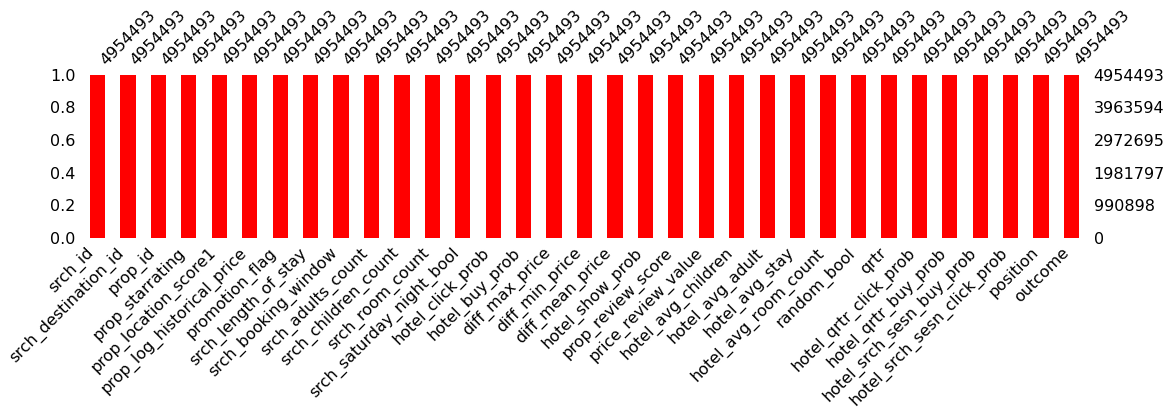

In [71]:

##changing nan or null values to 0
train1.replace([np.inf, -np.inf], 0, inplace=True)

train1=train1.dropna(axis=1,how="any")
msn.bar(train1,figsize=(18,3), color='red')

In [72]:
##ordering columns and selecting predictors + outcome
train1 = train1[['srch_id', 'srch_destination_id', 'prop_id', 'prop_starrating', 'prop_location_score1','prop_log_historical_price','promotion_flag','srch_length_of_stay','srch_booking_window','srch_adults_count','srch_children_count','srch_room_count','srch_saturday_night_bool', 'hotel_click_prob', 'hotel_buy_prob','diff_max_price','diff_min_price','diff_mean_price','hotel_show_prob', 'prop_review_score','price_review_value', 'hotel_avg_children','hotel_avg_adult','hotel_avg_stay','hotel_avg_room_count','random_bool','qrtr','hotel_qrtr_click_prob', 'hotel_qrtr_buy_prob', 'hotel_srch_sesn_buy_prob','hotel_srch_sesn_click_prob', 'position','outcome']]

In [73]:
# #splitting dataset 
# X = train1.iloc[:, :-1].values
# y = train1.iloc[:, -1].values

In [74]:
# train1.head(20)

In [75]:
# from sklearn.model_selection import GroupShuffleSplit

# def remove_columns(x1, ignore_column=["srch_id", "prop_id", "position", "random_bool", 'outcome']):
#     ignore_column = [c for c in ignore_column if c in x1.columns.values]
#     # print('Dropping columns: {}'.format(ignore_column))
#     # ignore_column_numbers = [x1.columns.get_loc(x) for x in ignore_column]
#     x1 = x1.drop(labels=ignore_column, axis=1)
#     # print('Columns after dropping: {}'.format(x1.columns.values))
#     return x1

# def input_estimated_position(training_data, srch_id_dest_id_dict):
#     training_data = training_data.merge(
#         srch_id_dest_id_dict, how="left", on=["srch_destination_id", "prop_id"]
#     )
#     print(training_data.head())
#     return training_data


# def split_train_data(data_for_training):
    
#     gss = GroupShuffleSplit(test_size=.85, n_splits=1, random_state = 7).split(data_for_training, groups=train1['srch_id'])

#     X_train_inds, X_test_inds = next(gss)

#     train_data= data_for_training.iloc[X_train_inds]
#     x1 = train_data.loc[:, ~train_data.columns.isin(['id','outcome'])]
#     y1 = train_data.loc[:, train_data.columns.isin(['outcome'])]

#     test_data= data_for_training.iloc[X_test_inds]

#     #We need to keep the id for later predictions
#     x2 = test_data.loc[:, ~test_data.columns.isin(['outcome'])]
#     y2 = test_data.loc[:, test_data.columns.isin(['outcome'])]


#     srch_id_dest_id_dict = x1.loc[x1["random_bool"] == 0]

#     # estimated position calculation
#     srch_id_dest_id_dict = x1.loc[x1["random_bool"] == 0]
#     srch_id_dest_id_dict = x1.groupby(["srch_destination_id", "prop_id"]).agg(
#         {"position": "mean"}
#     )
#     srch_id_dest_id_dict = srch_id_dest_id_dict.rename(
#         index=str, columns={"position": "estimated_position"}
#     ).reset_index()
#     srch_id_dest_id_dict["srch_destination_id"] = (
#         srch_id_dest_id_dict["srch_destination_id"].astype(str).astype(int)
#     )
#     srch_id_dest_id_dict["prop_id"] = (
#         srch_id_dest_id_dict["prop_id"].astype(str).astype(int)
#     )
#     srch_id_dest_id_dict["estimated_position"] = (
#         1 / srch_id_dest_id_dict["estimated_position"]
#     )
#     x1 = input_estimated_position(x1, srch_id_dest_id_dict)
#     x2 = input_estimated_position(x2, srch_id_dest_id_dict)

#     groups = x1["srch_id"].value_counts(sort=False).sort_index()
#     eval_groups = x2["srch_id"].value_counts(sort=False).sort_index()
#     len(eval_groups), len(x2), len(x1), len(groups)

#     x1 = remove_columns(x1)
#     x2 = remove_columns(x2)
#     return (x1, x2, y1, y2, groups, eval_groups, srch_id_dest_id_dict)

# method = "dart"
# lr = 0.12
# x1, x2, y1, y2, groups, eval_groups, srch_id_dest_id_dict = split_train_data(train1)

In [76]:
del train
del train_reduced

NameError: name 'train' is not defined

In [77]:
from sklearn.model_selection import GroupShuffleSplit

def remove_columns(x1, ignore_column=["srch_id", "prop_id", "position", "random_bool", 'outcome']):
    ignore_column = [c for c in ignore_column if c in x1.columns.values]
    # print('Dropping columns: {}'.format(ignore_column))
    # ignore_column_numbers = [x1.columns.get_loc(x) for x in ignore_column]
    x1 = x1.drop(labels=ignore_column, axis=1)
    # print('Columns after dropping: {}'.format(x1.columns.values))
    return x1

def input_estimated_position(training_data, srch_id_dest_id_dict):
    training_data = training_data.merge(
        srch_id_dest_id_dict, how="left", on=["srch_destination_id", "prop_id"]
    )
    print(training_data.head())
    return training_data


def split_train_data(data_for_training):
    
    gss = GroupShuffleSplit(test_size=.85, n_splits=1, random_state = 7).split(data_for_training, groups=train1['srch_id'])

    X_train_inds, X_test_inds = next(gss)

    train_data= data_for_training.iloc[X_train_inds]
    x1 = train_data.loc[:, ~train_data.columns.isin(['id','outcome'])]
    y1 = train_data.loc[:, train_data.columns.isin(['outcome'])]

    test_data= data_for_training.iloc[X_test_inds]

    #We need to keep the id for later predictions
    x2 = test_data.loc[:, ~test_data.columns.isin(['outcome'])]
    y2 = test_data.loc[:, test_data.columns.isin(['outcome'])]


    srch_id_dest_id_dict = x1.loc[x1["random_bool"] == 0]

    # estimated position calculation
#     srch_id_dest_id_dict = x1.loc[x1["random_bool"] == 0]
#     srch_id_dest_id_dict = x1.groupby(["srch_destination_id", "prop_id"]).agg(
#         {"position": "mean"}
#     )
#     srch_id_dest_id_dict = srch_id_dest_id_dict.rename(
#         index=str, columns={"position": "estimated_position"}
#     ).reset_index()
#     srch_id_dest_id_dict["srch_destination_id"] = (
#         srch_id_dest_id_dict["srch_destination_id"].astype(str).astype(int)
#     )
#     srch_id_dest_id_dict["prop_id"] = (
#         srch_id_dest_id_dict["prop_id"].astype(str).astype(int)
#     )
#     srch_id_dest_id_dict["estimated_position"] = (
#         1 / srch_id_dest_id_dict["estimated_position"]
#     )
#     x1 = input_estimated_position(x1, srch_id_dest_id_dict)
#     x2 = input_estimated_position(x2, srch_id_dest_id_dict)

    groups = x1["srch_id"].value_counts(sort=False).sort_index()
    eval_groups = x2["srch_id"].value_counts(sort=False).sort_index()
    len(eval_groups), len(x2), len(x1), len(groups)

    x1 = remove_columns(x1)
    x2 = remove_columns(x2)
    return (x1, x2, y1, y2, groups, eval_groups, srch_id_dest_id_dict)

method = "dart"
lr = 0.12
x1, x2, y1, y2, groups, eval_groups, srch_id_dest_id_dict = split_train_data(train1)

In [78]:
# %%time

# def train_model(x1, x2, y1, y2, groups, eval_groups, lr, method, name_of_model=None):
#     if not name_of_model:
#         name_of_model = str(int(time.time()))

#     clf = lgb.LGBMRanker(
#         objective="lambdarank",
#         metric="ndcg",
#         n_estimators=20,
#         learning_rate=lr,
#         max_position=5,
#         label_gain=[0, 1,2,3,4,5, 6],
#         random_state=69,
#         seed=69,
#         boosting=method,
#     )
#     gc.collect()

#     print("Training on train set with columns: {}".format(x1.columns.values))
#     clf.fit(
#         x1,
#         y1,
#         eval_set=[(x1, y1), (x2, y2)],
#         eval_group=[groups, eval_groups],
#         group=groups,
#         eval_at=5,
#         verbose=20,
#         early_stopping_rounds=600,
#         #categorical_feature=categorical_features_numbers,
#     )
    
#     print('done')
#     #gc.collect()
#     #pickle.dump(clf, open(os.path.join(output_dir, "model.dat"), "wb"))
#     pickle.dump(clf, open(os.path("model.dat", "wb")))
#     return clf

# model = train_model(x1, x2, y1, y2, groups, eval_groups, lr, method)

In [79]:
%%time
name_of_model=None

if not name_of_model:
    name_of_model = str(int(time.time()))

clf = lgb.LGBMRanker(
    objective="lambdarank",
    metric="ndcg",
    n_estimators=1000,
    learning_rate=lr,
    max_position=5,
    label_gain=[0, 1,2,3,4,5, 6],
    random_state=69,
    seed=69,
    boosting=method,)
gc.collect()

print("Training on train set with columns: {}".format(x1.columns.values))
model = clf.fit(
    x1,
    y1,
    eval_set=[(x1, y1), (x2, y2)],
    eval_group=[groups, eval_groups],
    group=groups,
    eval_at=5,
    verbose=20,
    early_stopping_rounds=200,
    #categorical_feature=categorical_features_numbers,
)
    
print('done')
print(model)
#gc.collect()
#pickle.dump(clf, open(os.path.join(output_dir, "model.dat"), "wb"))
#pickle.dump(model, open(os.path("model.dat", "wb")))



Training on train set with columns: ['srch_destination_id' 'prop_starrating' 'prop_location_score1'
 'prop_log_historical_price' 'promotion_flag' 'srch_length_of_stay'
 'srch_booking_window' 'srch_adults_count' 'srch_children_count'
 'srch_room_count' 'srch_saturday_night_bool' 'hotel_click_prob'
 'hotel_buy_prob' 'diff_max_price' 'diff_min_price' 'diff_mean_price'
 'hotel_show_prob' 'prop_review_score' 'price_review_value'
 'hotel_avg_children' 'hotel_avg_adult' 'hotel_avg_stay'
 'hotel_avg_room_count' 'qrtr' 'hotel_qrtr_click_prob'
 'hotel_qrtr_buy_prob' 'hotel_srch_sesn_buy_prob'
 'hotel_srch_sesn_click_prob']


C:\Users\Admin\Documents\Masters College\datamining\assignment2\.venv\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Admin\Documents\Masters College\datamining\assignment2\.venv\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: max_position
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] seed is set=69, random_state=69 will be ignored. Current value: seed=69


C:\Users\Admin\Documents\Masters College\datamining\assignment2\.venv\lib\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[20]	training's ndcg@5: 0.530661	valid_1's ndcg@5: 0.512333
[40]	training's ndcg@5: 0.53817	valid_1's ndcg@5: 0.517429
[60]	training's ndcg@5: 0.545242	valid_1's ndcg@5: 0.519846
[80]	training's ndcg@5: 0.548734	valid_1's ndcg@5: 0.521598
[100]	training's ndcg@5: 0.556305	valid_1's ndcg@5: 0.52459
[120]	training's ndcg@5: 0.574308	valid_1's ndcg@5: 0.537249
[140]	training's ndcg@5: 0.582994	valid_1's ndcg@5: 0.542515
[160]	training's ndcg@5: 0.589904	valid_1's ndcg@5: 0.547786
[180]	training's ndcg@5: 0.593292	valid_1's ndcg@5: 0.548242
[200]	training's ndcg@5: 0.599035	valid_1's ndcg@5: 0.551012
[220]	training's ndcg@5: 0.602626	valid_1's ndcg@5: 0.551868
[240]	training's ndcg@5: 0.609102	valid_1's ndcg@5: 0.55409
[260]	training's ndcg@5: 0.613684	valid_1's ndcg@5: 0.555326
[280]	training's ndcg@5: 0.61809	valid_1's ndcg@5: 0.559337
[300]	training's ndcg@5: 0.623364	valid_1's ndcg@5: 0.561687
[320]	training's ndcg@5: 0.62802	valid_1's ndcg@5: 0.563233
[340]	training's ndcg@5: 0.634111

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,x2.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

In [93]:
# # writing the results to a dataframe to analyse seperatly if needed ( ie how many false negatives, check values ect)

# result = pd.DataFrame(y1, columns=['actual'])
# predicted= pd.DataFrame(y2, columns=['predicted'])

# df = pd.DataFrame(X_test)
# df['result'] = result
# df['perdicted'] = predicted
# df.to_csv('results2.csv')
# df.head()

In [94]:
###################### pred 

In [95]:
#### import competition dataset 

to_pred=pd.read_csv("test_set_VU_DM.csv")
#test=pd.read_csv("test_set_VU_DM.csv")

to_drop= ['comp1_rate',
'comp1_inv',
'comp1_rate_percent_diff',
'comp2_rate',
'comp2_inv',
'comp2_rate_percent_diff',
'comp3_rate',
'comp3_inv',
'comp3_rate_percent_diff',
'comp4_rate',
'comp4_inv',
'comp4_rate_percent_diff',
'comp5_rate',
'comp5_inv',
'comp5_rate_percent_diff',
'comp6_rate',
'comp6_inv',
'comp6_rate_percent_diff',
'comp7_rate',
'comp7_inv',
'comp7_rate_percent_diff',
'comp8_rate',
'comp8_inv',
'comp8_rate_percent_diff'

]

#train['outcome'] = pd.Series(train['booking_bool']> 0, 500 + train['position'] , train['click_bool']> 0, 100 +train['position'] , 0 + train['position'] )



to_pred = to_pred.drop(to_drop,  axis=1)#.sample(frac=0.2, replace=True, random_state=1)
#test_reduced  = test.iloc[: , :N].sample(frac=0.33, replace=True, random_state=1)


In [96]:
# creating same features as test data

to_pred['date_time'] = pd.to_datetime(to_pred['date_time'], errors='coerce')
to_pred["weekday"] = to_pred["date_time"].dt.weekday
to_pred["week_of_year"] = to_pred["date_time"].dt.week
to_pred["month"] = to_pred["date_time"].dt.month
to_pred["hour"] = to_pred["date_time"].dt.hour
to_pred["time_epoch"] = to_pred["date_time"].astype('int64')//1e9
to_pred["time_epoch"] = to_pred["date_time"].astype('int64')//1e9
to_pred.loc[ to_pred['hour'] < 6, 'day_time'] = 1
to_pred.loc[(to_pred['hour'] >=6) & (to_pred['hour'] <= 11), 'day_time'] = 2
to_pred.loc[(to_pred['hour'] >= 12) & (to_pred['hour'] <= 17), 'day_time'] = 3
to_pred.loc[(to_pred['hour'] > 18) , 'day_time'] = 4

##################

to_pred['srch_for_date'] = to_pred['date_time']  + pd.to_timedelta(to_pred['srch_booking_window'], unit='D')
to_pred["srch_for_month"] = to_pred["srch_for_date"].dt.month

#train['srch_for_date'] = train['date_time']  + pd.to_timedelta(train['srch_booking_window'], unit='D')
#train["srch_for_month"] = train["srch_for_date"].dt.month
to_pred.loc[ to_pred['srch_for_month'] <= 3, 'seasonality'] = 1
to_pred.loc[(to_pred['srch_for_month'] > 3) & (to_pred['srch_for_month'] <= 6), 'seasonality'] = 2
to_pred.loc[(to_pred['srch_for_month'] > 6) & (to_pred['srch_for_month'] <= 9), 'seasonality'] = 3
to_pred.loc[(to_pred['srch_for_month'] > 9) , 'seasonality'] = 4

to_pred.loc[ to_pred['month'] <= 3, 'qrtr'] = 1
to_pred.loc[(to_pred['month'] > 3) & (to_pred['month'] <= 6), 'qrtr'] = 2
to_pred.loc[(to_pred['month'] > 6) & (to_pred['month'] <= 9), 'qrtr'] = 3
to_pred.loc[(to_pred['month'] > 9) , 'qrtr'] = 4

####################

to_pred['price_bin'] = pd.qcut(to_pred['price_usd'], q=80, precision=0)
to_pred['mean_price_bin_star'] = to_pred.groupby('price_bin')['prop_starrating'].transform('mean')
to_pred['mean_price_bin_review'] = to_pred.groupby('price_bin')['prop_review_score'].transform('mean')
to_pred['prop_review_score'] = to_pred['prop_review_score'].fillna(0)
to_pred.loc[to_pred.prop_review_score == 0, "prop_review_score"] = to_pred.mean_price_bin_review
to_pred.loc[to_pred.prop_starrating == 0, "prop_starrating"] = to_pred.mean_price_bin_star

##################

to_pred['max_price'] = to_pred.groupby('srch_id')['price_usd'].transform('max') 
to_pred['min_price'] = to_pred.groupby('srch_id')['price_usd'].transform('min') 
to_pred['mean_price'] = to_pred.groupby('srch_id')['price_usd'].transform('mean') 
to_pred['diff_max_price'] =(to_pred['max_price'] -to_pred['price_usd']) / to_pred['price_usd']
to_pred['diff_min_price'] = (to_pred['min_price'] - to_pred['price_usd'])/ to_pred['price_usd']
to_pred['diff_min_price'] = to_pred['diff_min_price'].replace(np.nan, 0)
to_pred['diff_mean_price'] = (to_pred['mean_price'] - to_pred['price_usd']) / to_pred['price_usd']
to_pred['price_review_value'] =  to_pred['prop_review_score'] /to_pred['mean_price_bin_review'] 

#################

to_pred['hotel_show_prob'] =  to_pred.groupby('prop_id')['prop_id'].transform('count') / (to_pred.srch_id.unique()).size


In [97]:
### mergeing hotel specific stats from test dataset 

to_pred_reduced = to_pred.merge(train_calcs, left_on=['prop_id'], right_on=['prop_id'], how='left')
hotel_click_stats = hotel_click_stats.drop_duplicates(subset=['prop_id'])
to_pred_reduced = to_pred_reduced.merge(hotel_click_stats, left_on=['prop_id'], right_on=['prop_id'], how='left')

In [98]:


#train_reduced = train_reduced.merge(train_clacs, on='prop_id', how='right', suffixes=('_1', '_2'))
#to_pred_reduced  = pd.concat([to_pred_reduced.set_index('prop_id'),train_calcs.set_index('prop_id')], axis=1, join='outer').reset_index()
#to_pred_reduced2  = pd.concat([to_pred_reduced.set_index('prop_id'),hotel_click_stats.set_index('prop_id')], axis=1, join='outer').reset_index()
to_pred_reduced['hotel_avg_children'] = to_pred_reduced['hotel_avg_children'].replace(np.nan, .367)
to_pred_reduced['hotel_avg_adult'] = to_pred_reduced['hotel_avg_adult'].replace(np.nan, 1.95)
to_pred_reduced['hotel_avg_stay'] = to_pred_reduced['hotel_avg_stay'].replace(np.nan, 2.09)
to_pred_reduced['hotel_avg_room_count'] = to_pred_reduced['hotel_avg_room_count'].replace(np.nan, 1.13)
to_pred_reduced[['hotel_click_prob', 'hotel_buy_prob']] = to_pred_reduced[['hotel_click_prob', 'hotel_buy_prob']].fillna(0)


#train_reduced.to_csv('hotel_calcs2.csv')

In [99]:
to_pred_reduced.isnull().mean() * 100

srch_id                         0.000000
date_time                       0.000000
site_id                         0.000000
visitor_location_country_id     0.000000
visitor_hist_starrating        94.889662
visitor_hist_adr_usd           94.865606
prop_country_id                 0.000000
prop_id                         0.000000
prop_starrating                 0.000000
prop_review_score               0.000000
prop_brand_bool                 0.000000
prop_location_score1            0.000000
prop_location_score2           21.939743
prop_log_historical_price       0.000000
price_usd                       0.000000
promotion_flag                  0.000000
srch_destination_id             0.000000
srch_length_of_stay             0.000000
srch_booking_window             0.000000
srch_adults_count               0.000000
srch_children_count             0.000000
srch_room_count                 0.000000
srch_saturday_night_bool        0.000000
srch_query_affinity_score      93.584467
orig_destination

In [100]:
###droppping unused columns 

to_drop = ['site_id', 'date_time', 'visitor_location_country_id', 'prop_country_id','price_bin', 'prop_brand_bool', 'orig_destination_distance', 'prop_location_score2'
          ,'price_usd','price_bin', 'max_price', 'srch_query_affinity_score','visitor_hist_starrating', 'visitor_hist_adr_usd', 'min_price', 'mean_price', 'mean_price_bin_review','mean_price_bin_star', 'bought',  'weekday', 'week_of_year', 'hour', 'time_epoch', 'random_bool', 'month', ] 

to_pred1 = to_pred_reduced.drop(to_drop,  axis=1)

<AxesSubplot:>

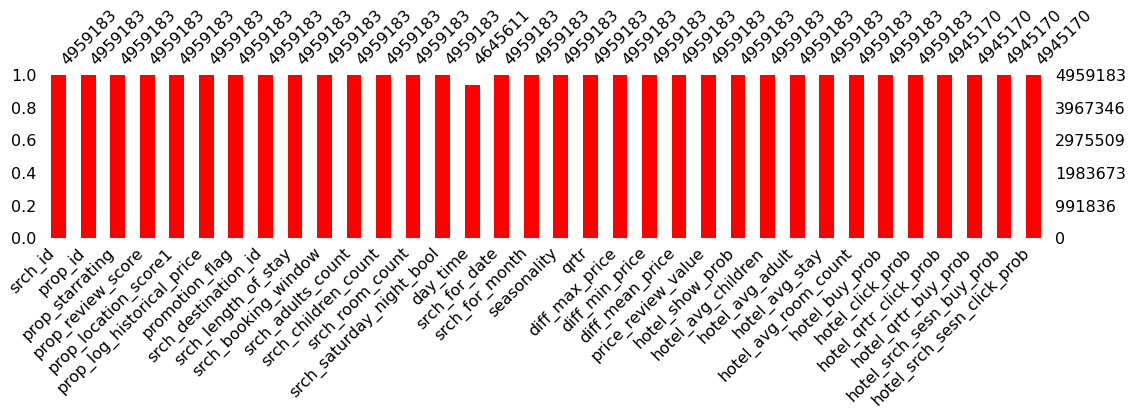

In [101]:
msn.bar(to_pred1,figsize=(18,3), color='red')

<AxesSubplot:>

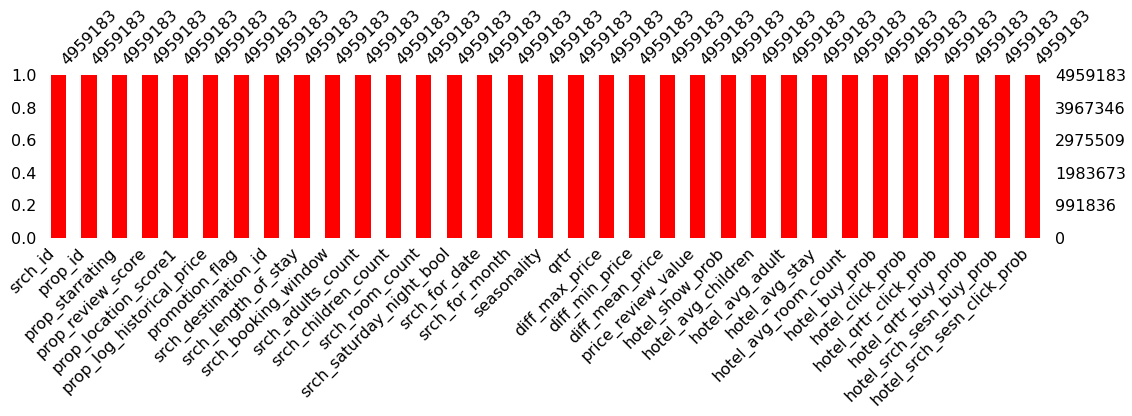

In [102]:
#replacing nulls and nans

to_pred1.replace([np.inf, -np.inf], 0, inplace=True)

to_pred1[['hotel_qrtr_click_prob', 'hotel_qrtr_buy_prob', 'hotel_srch_sesn_buy_prob', 'hotel_srch_sesn_click_prob']] = to_pred1[['hotel_qrtr_click_prob', 'hotel_qrtr_buy_prob', 'hotel_srch_sesn_buy_prob', 'hotel_srch_sesn_click_prob']].replace(np.nan, 0)

to_pred1=to_pred1.dropna(axis=1,how="any")
msn.bar(to_pred1,figsize=(18,3), color='red')

In [103]:
##ordering df and selecting predictors
to_pred1 = to_pred1[['srch_id', 'srch_destination_id', 'prop_id','prop_starrating', 'prop_location_score1','prop_log_historical_price','promotion_flag','srch_length_of_stay','srch_booking_window','srch_adults_count','srch_children_count','srch_room_count','srch_saturday_night_bool', 'hotel_click_prob', 'hotel_buy_prob','diff_max_price','diff_min_price','diff_mean_price','hotel_show_prob', 'prop_review_score','price_review_value', 'hotel_avg_children','hotel_avg_adult','hotel_avg_stay','hotel_avg_room_count','qrtr','hotel_qrtr_click_prob', 'hotel_qrtr_buy_prob', 'hotel_srch_sesn_buy_prob','hotel_srch_sesn_click_prob']]

#to_pred1 = to_pred1[['srch_destination_id', 'prop_starrating', 'prop_location_score1','prop_log_historical_price','promotion_flag','srch_length_of_stay','srch_booking_window','srch_adults_count','srch_children_count','srch_room_count','srch_saturday_night_bool', 'hotel_click_prob', 'hotel_buy_prob','diff_max_price','diff_min_price','diff_mean_price','hotel_show_prob', 'prop_review_score','price_review_value', 'hotel_avg_children','hotel_avg_adult','hotel_avg_stay','hotel_avg_room_count','random_bool','qrtr','hotel_qrtr_click_prob', 'hotel_qrtr_buy_prob', 'hotel_srch_sesn_buy_prob','hotel_srch_sesn_click_prob']]

In [104]:


#gc.collect()

#model = pickle.load(open(os.path.join(output_dir, "model.dat"), "rb"))

#test_data = test_data.copy()
#test_data = input_estimated_position(test_data, srch_id_dest_id_dict)

test_data_srch_id_prop_id = to_pred1[["srch_id", "prop_id"]]

to_pred1 = to_pred1.drop(['prop_id', "srch_id" ],axis =1)
#test_data = remove_columns(test_data)

#categorical_features_numbers = get_categorical_column(test_data)

print("Predicting on train set with columns: {}".format(to_pred1.columns.values))
#kwargs = {}
#kwargs = {"categorical_feature": categorical_features_numbers}

predictions = model.predict(to_pred1)
test_data_srch_id_prop_id["prediction"] = predictions
del to_pred1
#gc.collect()


Predicting on train set with columns: ['srch_destination_id' 'prop_starrating' 'prop_location_score1'
 'prop_log_historical_price' 'promotion_flag' 'srch_length_of_stay'
 'srch_booking_window' 'srch_adults_count' 'srch_children_count'
 'srch_room_count' 'srch_saturday_night_bool' 'hotel_click_prob'
 'hotel_buy_prob' 'diff_max_price' 'diff_min_price' 'diff_mean_price'
 'hotel_show_prob' 'prop_review_score' 'price_review_value'
 'hotel_avg_children' 'hotel_avg_adult' 'hotel_avg_stay'
 'hotel_avg_room_count' 'qrtr' 'hotel_qrtr_click_prob'
 'hotel_qrtr_buy_prob' 'hotel_srch_sesn_buy_prob'
 'hotel_srch_sesn_click_prob']


In [105]:
test_data_srch_id_prop_id = test_data_srch_id_prop_id.sort_values(['srch_id', 'prediction'],ascending = [True, False])
test_data_srch_id_prop_id1 = test_data_srch_id_prop_id.drop(['prediction'], axis = 1)
test_data_srch_id_prop_id1.to_csv('submission.csv', index=False)

test_data_srch_id_prop_id1.head(5)

,srch_id,prop_id
5,1,28181
23,1,99484
9,1,54937
1,1,5543
0,1,3180


In [ ]:
# ## saving serch_id and prod_id for use in submission file 

# ids = to_pred1[['srch_id', 'prop_id']]

# to_drop = ['srch_id','prop_id']

# to_pred1 = to_pred1.drop(to_drop,  axis=1)

# ###### perdicitng outcome using model

# y_pred=l[1][0].predict(to_pred1)

# print(y_pred)

# y_pred[:5]

In [ ]:

# ###creating submission file

# predicted= pd.DataFrame(y_pred, columns=['predicted'])

# df = pd.DataFrame(to_pred1)

# df['perdicted'] = predicted

# df[['srch_id', 'prop_id']] = ids[['srch_id', 'prop_id']]

# df = df[['srch_id', 'prop_id', 'perdicted','hotel_buy_prob']]

# ##ordering submission file 


# df = df.sort_values(['srch_id', 'perdicted', 'hotel_buy_prob'],
#               ascending = [True, False,False])
# df = df.drop(['perdicted', 'hotel_buy_prob'], axis = 1)
# df.to_csv('submission.csv', index=False)

# df.head(5)